In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pylab

# Likhtman-McLeish Model (LM Model)
ref: Likhtman, A. E.; McLeish, T. C. B. "Quantitative Theory for Linear Dynamics of Linear Entangled Polymers". *Macromolecules* __2002__, 35, 6332-6343.  

$$
G(t) = G_e \left[
\frac{4}{5} \mu(t) R(t) + 
\frac{1}{5Z}\sum^{Z-1}_{p=1}\exp \left(-\frac{p^2t}{\tau_R}\right) + 
\frac{1}{Z}\sum^{N}_{p=Z} \exp \left( -\frac{2p^2t}{\tau _ R}\right)
\right]
$$
$$\begin{align}
G'(\omega) &= \omega \int_0^\infty G(t) \sin \omega t \ dt \\
G''(\omega) &= \omega \int_0^\infty G(t) \cos \omega t \ dt \\
G^*(\omega) &= G'(\omega) + iG''(\omega)\\
&=i\omega \int_0^\infty G(t) e^{-i\omega t} \ dt \\
e^{i\omega t} &= \cos \omega t + i \sin \omega t \\
e^{-i\omega t} &= \cos \omega t - i \sin \omega t
\end{align}
$$
The first term is the contributions due to escape from the tube described by $\mu(t)$ and $R(t)$.  
The second term is longitudinal modes relaxation.  
The third term is fast Rouse motion inside the tube.  
$\mu(t)$: the tube-segment occupation function;  
$R(t)$: the constraint release relaxation function;  
$$
R(t,v_{\nu}) = 1 - \frac{C_R}{Z}\left( \frac{c_{\nu}t}{\tau_e} \right)^{1/4} , C_R \approx  1.8
$$

$$
\begin{align}
\mu(t) &= \frac{8\tilde{G}_f}{\pi^2} \sum_{p=1,odd}^{p^*} \frac{1}{p^2} \exp \left( - \frac{tp^2}{\tau_{df}} \right) &+ 
\int_{\epsilon^*}^{\infty} \frac{0.306}{Z\tau_e^{1/4}\epsilon^{5/4}} \exp (-\epsilon t) d \epsilon \\
&= ... &+ \int_{\ln \epsilon^*}^{\infty} \frac{0.306}{Z(\tau_e\epsilon)^{1/4}} \exp (-\epsilon t) d \ln \epsilon
\end{align}
$$
Here:
$$
\epsilon^* = \frac{1}{\tau_eZ^4} \left(\frac{4\times 0.316}{1 - 8 \tilde{G}_f / \pi^2 \sum_{p=1,odd}^{p^*}\frac{1}{p^2}}\right)^4 ,  p^* \sim  \sqrt{Z/10}
$$
$$
\tau_{df}(Z)/\tau_d^{(0)}(Z) = 1- \frac{2C_1}{Z^{1/2}} + \frac{C_2}{Z} + \frac{C_3}{Z^{3/2}}
$$
$$
\tilde G_f(Z) = 1 - \frac{C_1}{Z^{1/2}} + \frac{C_4}{Z} + \frac{C_5}{Z^{3/2}}
$$
By fitting simulation data for Z = 2 ~ 100 gives:
$$
C_1 = 1.69; C_2 = 4.17; C_3 = -1.55; C_4 = 2.0; C_5 = -1.24
$$

$\tau_d^{(0)}$ is the reptation or disentanglement time, and $\tau_d^{(0)} = 3Z^3\tau_e$

## Density of Polystyrene
ref: Kremer, K. et. al. Macromolecules 2011, 44, 393-402.  
when $T > 100 ^oC$:  
$$\rho(T) = 1∕(0.8165+4.5×10^{−4} 𝑇)  $$  
when $T < 100 ^oC$:  
$$\rho(T) = 1∕(0.9486+5×10^{−5} 𝑇)  $$

Note that: the unit of $\rho$ is $g/cm^3$, T is the absolute temperature.

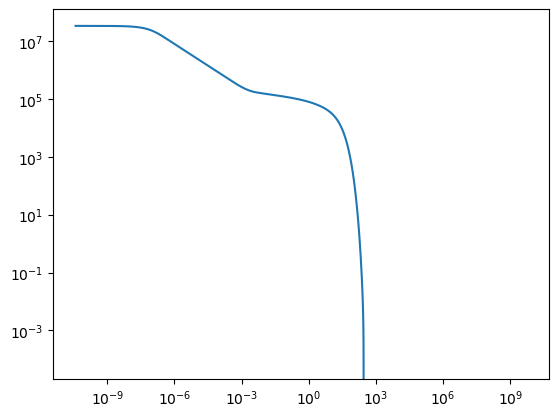

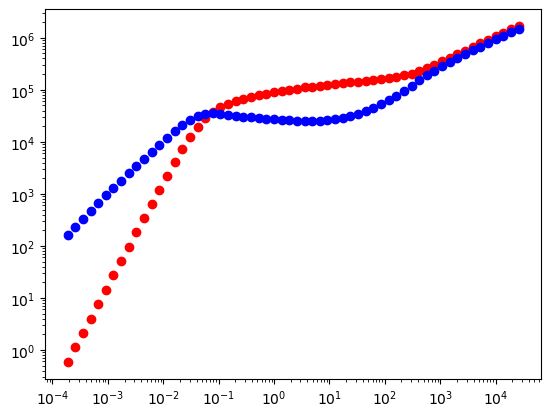

In [13]:
#Parameters of LM model to calculate the G(t)
τe = 3.85e-3 #second
Me = 17e3 # Polystyrene
cnu = 0.1 
Mw = 283e3 # Polystyrene 283k
T = 150 + 273.15
ρ = 1E6/(0.8165+4.5E-4*T)  #g/m^3
Ge = ρ * T * 8.314 / Me

Z = Mw / Me
τR = τe * Z**2
M0 = 104.1 # Polystyrene
N = np.round(Mw/M0)

C1 = 1.69
C2 = 4.17
C3 = -1.55
C4 = 2.0
C5 = -1.24
τd = 3 * τe * Z**3
t_span = np.logspace(np.log10(τe) - 8, np.log10(τd) + 8, 10000)
#
τdf = τd * (1.0 - 2 * C1 / Z**0.5 + C2 / Z + C3 / Z**1.5)
Gf = 1- C1/Z**0.5 + C4/Z + C5/Z**1.5
p_star = (Z/10)**0.5
ε_star = 1/τe/Z**4 * (4 * 0.316 / (1 - 8*Gf/np.pi**2 * np.sum(1/(np.arange(1,p_star,2))**2)))**4
CR = 1.8
Rt = 1 - CR/Z * (cnu * t_span/τe)**(1/4)
lnε_span = np.linspace(np.log(ε_star), np.log(1/τe) + 10, 1000)
dlnε = np.abs(np.mean(np.diff(lnε_span)))
ε_span = np.exp(lnε_span)
#calculate μt
μt = np.zeros_like(t_span)
p = np.arange(1,p_star, 2)
for ind , t in enumerate(t_span):
    μt_right1 = 8 * Gf /np.pi**2 * np.sum(np.exp(-t*p**2/τdf)/p**2)
    μt_right2 = np.sum(0.306/Z/(τe*ε_span)**(1/4)*np.exp(-ε_span*t)) * dlnε
    μt[ind] = μt_right1 + μt_right2
Gt_right1 = Ge * (4/5*μt*Rt)
Gt_right2 = np.zeros_like(t_span)
Gt_right3 = np.zeros_like(t_span)
for ind,t in enumerate(t_span):
        Gt_right2[ind] = Ge/5/Z * np.sum(np.exp(-np.arange(1,Z-1,1)**2 * t / τR))
        Gt_right3[ind] = Ge/Z * np.sum(np.exp(-2*np.arange(np.round(Z),N)**2 * t / τR))
Gt = Gt_right1 + Gt_right2 + Gt_right3
#t_span = t_span[Gt>0]
#Gt = Gt[Gt>0]
#plot the G(t)
pylab.loglog(t_span,Gt)

#Convert G(t) to G(ω) by numeric fourier transform
func = sp.interpolate.interp1d(t_span, Gt, kind='quadratic')
ω_span = np.logspace(np.log10(1/τd)-2,np.log10(1/τe)+2,60)
G1 = np.zeros_like(ω_span)
G2 = np.zeros_like(ω_span)
for ind,ω in enumerate(ω_span):
    t_span_linear_window = np.linspace(1e-3/ω, 1e4/ω, int(1e7+1))
    dt = np.abs(t_span_linear_window[1]-t_span_linear_window[0])
    Gt_window = func(t_span_linear_window)
    G1[ind] = ω * np.sum(Gt_window * np.sin(ω * t_span_linear_window)) * dt
    G2[ind] = ω * np.sum(Gt_window * np.cos(ω * t_span_linear_window)) * dt
pylab.figure()
pylab.loglog(ω_span, G1, 'ro', ω_span, G2, 'bo')

#export data
file_path = "τe{}_Ge{:.0f}_Mw{:.0f}_Me{:.0f}.txt".format(τe,Ge,Mw,Me)
with open(file_path, mode="w") as file:
    file.write("Freq\tG1\tG2\n")
    for ind,ω in enumerate(ω_span):
        line = "{}\t{}\t{}".format(ω,G1[ind],G2[ind])
        file.write(line + "\n")         # Write the line and add a newline

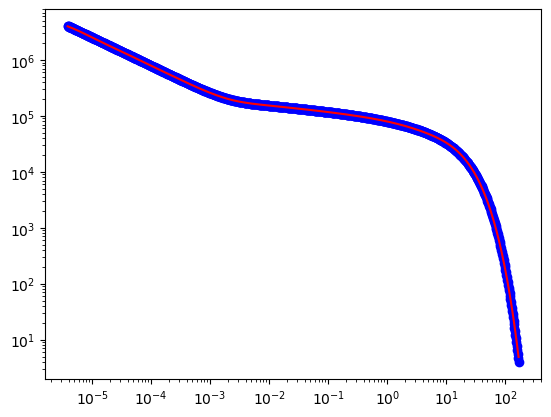

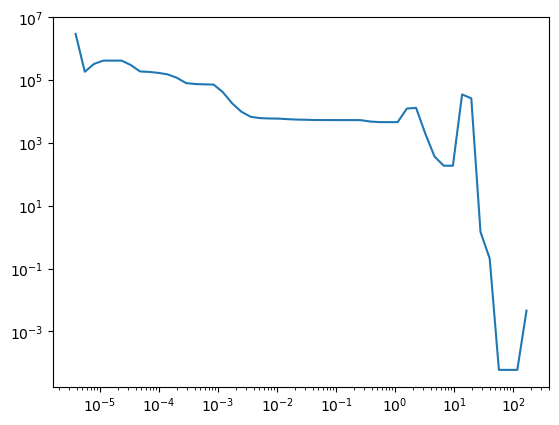

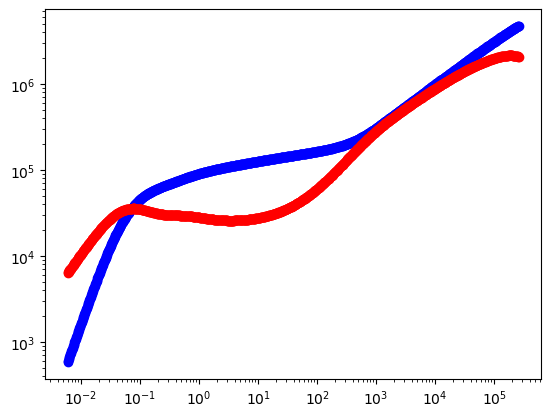

In [82]:
def Gt_maxwell(g, τd, t_span):
    Gti = t_span * 0
    for τdi, gi in zip(τd,g):
        Gti += gi * np.exp(-t_span/τdi)
    return Gti

def Gt_maxwell_for_fit(g_log, τd, t_span, Gt_exp):
    Gti = t_span * 0
    for τdi, gi in zip(τd, 10**g_log):
        Gti += gi * np.exp( - t_span/τdi)
    return np.append(np.log10(Gti) - np.log10(Gt_exp), 0.2*np.mean(np.abs(np.diff(g_log))))

#Maxell model
def maxwell(g, τd, ω):
    G1=ω * 0
    G2=ω * 0
    for τdi,gi in zip(τd,g):
        G1 += gi * ω**2 * τdi**2 / (ω**2 * τdi**2 + 1)
        G2 += gi * ω * τdi/(ω**2 * τdi**2 + 1)
    return (G1, G2)


τd_v = np.logspace(np.log10(t_span[0]),np.log10(t_span[-1]),50)
g_log_0_v = np.log10(1e6*τd_v[0]**2/τd_v**2)
least_squares = sp.optimize.least_squares
res = least_squares(Gt_maxwell_for_fit, g_log_0_v, args=(τd_v,t_span,Gt))
g_v = 10**(res.x)
Gt_model = Gt_maxwell(g_v,τd_v,t_span)
pylab.loglog(t_span, Gt,'bo',t_span,Gt_model,'r-')
#pylab.loglog(df_experiment.loc[:,'G1'],'o')
pylab.figure()
pylab.loglog(τd_v, g_v)

#
pylab.figure()
ω_span = 1/t_span
G1,G2 = maxwell(g_v, τd_v, ω_span)
pylab.loglog(ω_span, G1,'bo',ω_span,G2,'ro')